<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

## Ejercicio

Construir QA Bot basado en el ejemplo del traductor pero con un dataset QA.

Recomendaciones:
- MAX_VOCAB_SIZE = 8000
- max_length ~ 10
- Embeddings 300 Fasttext
- n_units = 128
- LSTM Dropout 0.2
- Epochs 30~50

Preguntas interesantes:
- Do you read?
- Do you have any pet?
- Where are you from?

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

### Datos
El objecto es utilizar datos disponibles del Tatoeba Project de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor de inglés a español seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

In [7]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Activation, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model



#### Cargamos un dataset que nos permita crear nuestro BotQA

In [9]:
# Esta celda se ejecuta una sola vez
!pip install datasets

In [10]:
from datasets import load_dataset
# Cargar la versión 1.1 del dataset SQuAD
squad = load_dataset("squad")

In [11]:
print("Pregunta:", squad['train'][0]['question'])
print("Contexto:", squad['train'][0]['context'])
print("Respuesta:", squad['train'][0]['answers']['text'][0])

Pregunta: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Contexto: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Respuesta: Saint Bernadette Soubirous


In [12]:
input_sentences = []              # "contexto [SEP] pregunta"
output_sentences = []            # "respuesta <eos>"
output_sentences_inputs = []     # "<sos> respuesta"

MAX_NUM_SAMPLES = 6000
count = 0

for sample in squad['train']:
    if count >= MAX_NUM_SAMPLES:
        break

    question = sample['question'].strip()
    context = sample['context'].strip()
    answers = sample['answers']['text']
    
    if not answers:
        continue
    
    answer = answers[0].strip()
    
    input_sentence = context + " [SEP] " + question
    output_sentence = answer + " <eos>"
    output_sentence_input = "<sos> " + answer

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)
    count += 1


In [14]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary. [SEP] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'Saint Bernadette Soubirous <eos>',
 '<sos> Saint Bernadette Soubirous')

### 2 - Preprocesamiento

In [16]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000
# Vamos a necesitar un tokenizador para cada idioma

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Tokenizador para input (contexto + pregunta)
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
word2idx_inputs = input_tokenizer.word_index
print("Palabras en vocabulario de entrada:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Longitud máxima de input:", max_input_len)

# Tokenizador para output (respuestas con <sos>, <eos>)
output_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token="<OOV>",
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'  # conservamos < y >
)
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences + output_sentences_inputs)


output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en vocabulario de salida:", len(word2idx_outputs))

max_output_len = max(len(sen) for sen in output_integer_seq)
print("Longitud máxima de output:", max_output_len)


Palabras en vocabulario de entrada: 16559
Longitud máxima de input: 532
Palabras en vocabulario de salida: 5750
Longitud máxima de output: 44


In [25]:
word2idx_outputs = output_tokenizer.word_index

print('<sos>' in word2idx_outputs)
print('<eos>' in word2idx_outputs)


True
True


In [27]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 50
max_out_len = 20

In [29]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len, padding='post')
decoder_input_sequences = pad_sequences(output_input_seq, maxlen=max_out_len, padding='post')
decoder_target_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
# lo que recibe el encoder (contexto + pregunta).
print("encoder_input_sequences shape:", encoder_input_sequences.shape)
#  lo que se alimenta al decoder durante el entrenamiento (<sos> + respuesta parcial).
print("decoder_input_sequences shape:", decoder_input_sequences.shape)
# lo que el modelo intenta predecir (respuesta + <eos>), desplazado.
print("decoder_target_sequences shape:", decoder_target_sequences.shape)

encoder_input_sequences shape: (6000, 50)
decoder_input_sequences shape: (6000, 20)
decoder_target_sequences shape: (6000, 20)


In [33]:
# from keras.utils import to_categorical
# decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
# decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
# decoder_targets.shape

### 3 - Preparar los embeddings

In [141]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque de código
# import os
# import gdown
# if os.access('gloveembedding.pkl', os.F_OK) is False:
#     url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
#     output = 'gloveembedding.pkl'
#     gdown.download(url, output, quiet=False)
# else:
#     print("Los embeddings gloveembedding.pkl ya están descargados")

import zipfile

with zipfile.ZipFile("wiki-news-300d-1M.vec.zip", "r") as zip_ref:
    zip_ref.extractall()

In [142]:
# # En caso de que gdown de algún error de permisos intentar descargar los
# # embeddings con curl:

# !curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

In [38]:
import numpy as np
import os
import pickle
import logging
from pathlib import Path

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        index = np.arange(self.embeddings.shape[0])
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        max_bytes = 2**28 - 1
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        return pickle.loads(bytes_in)

    def convert_model_to_pickle(self):
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as f:
            embeddings_gen = (
                (line.split()[0], np.array(line.split()[1:], dtype=np.float32))
                for line in f if len(line.split()) == self.N_FEATURES + 1
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), 2**28 - 1):
                f_out.write(bytes_out[idx:idx + (2**28 - 1)])
        return embeddings

# Subclase para embeddings FastText desde Wikipedia
class FasttextWikiEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'wiki-news-300d-1M.vec'  # Asegurate que este archivo esté en el entorno
    PKL_PATH = 'fasttext_wiki.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

# Inicializar
fasttext_embeddings = FasttextWikiEmbeddings()

# Construir la matriz de embeddings para el encoder
embedding_dim = 300
num_words_encoder = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words_encoder, embedding_dim))

for word, idx in word2idx_inputs.items():
    if idx >= MAX_VOCAB_SIZE:
        continue
    embedding_idx = fasttext_embeddings.word2idx.get(word)
    if embedding_idx is not None:
        embedding_matrix[idx] = fasttext_embeddings.embeddings[embedding_idx]['embedding']


# class GloveEmbeddings(WordsEmbeddings):
#     WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
#     PKL_PATH = 'gloveembedding.pkl'
#     N_FEATURES = 50
#     WORD_MAX_SIZE = 60

# class FasttextEmbeddings(WordsEmbeddings):
#     WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
#     PKL_PATH = 'fasttext.pkl'
#     N_FEATURES = 300
#     WORD_MAX_SIZE = 60

In [144]:
# # Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
# model_embeddings = GloveEmbeddings()

In [40]:
# Crear la Embedding matrix de las secuencias

print('preparing embedding matrix...')
embed_dim = fasttext_embeddings.N_FEATURES
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs))  # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = fasttext_embeddings.get_words_embeddings([word])[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))


preparing embedding matrix...
number of null word embeddings: 735


In [42]:
# # Dimensión de los embeddings de la secuencia en inglés
# embedding_matrix.shape

### 4 - Entrenar el modelo

In [45]:
max_input_len

50

In [47]:
n_units = 128

# Encoder
encoder_inputs = Input(shape=(max_input_len,))
encoder_embedding_layer = Embedding(
    input_dim=nb_words,
    output_dim=embed_dim,
    input_length=max_input_len,
    weights=[embedding_matrix],
    trainable=False
)
encoder_inputs_x = encoder_embedding_layer(encoder_inputs)
encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# Decoder
num_words_output = min(MAX_VOCAB_SIZE, len(word2idx_outputs) + 1)
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(
    input_dim=num_words_output,
    output_dim=n_units,
    input_length=max_out_len
)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo final
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()


C:\Users\Chelo\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 300)   │  2,400,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 20, 128)   │    736,128 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │    219,648 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 20, 128), │    131,584 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20, 5751)  │    741,879 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,229,239 (16.13 MB)

 Trainable params: 1,829,239 (6.98 MB)

 Non-trainable params: 2,400,000 (9.16 MB)

In [49]:
# Modelo solo decoder para inferencia (predicción paso a paso)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Inputs para los estados ocultos
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Entrada de una sola palabra
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# LSTM en modo inferencia
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo del decoder para inferencia
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)


In [61]:
import os

# Expandir dimensión del target
decoder_target_data = np.expand_dims(decoder_target_sequences, -1)

# Archivo donde se guardarán los pesos (nombre corregido)
weights_file = "qa_seq2seq.weights.h5"  # ← termina en `.weights.h5`

# ¿Ya existen pesos guardados?
if os.path.exists(weights_file):
    print("Cargando pesos previamente entrenados...")
    model.load_weights(weights_file)
else:
    print("Entrenando el modelo...")
    hist = model.fit(
        [encoder_input_sequences, decoder_input_sequences],
        decoder_target_data,
        batch_size=64,
        epochs=50,
        validation_split=0.2
    )
    # Guardar los pesos una vez entrenado
    model.save_weights(weights_file)
    print("Pesos guardados en:", weights_file)




Entrenando el modelo...
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.9277 - loss: 0.4104 - val_accuracy: 0.7793 - val_loss: 2.6558
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.9288 - loss: 0.4025 - val_accuracy: 0.7785 - val_loss: 2.6577
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.9309 - loss: 0.3876 - val_accuracy: 0.7795 - val_loss: 2.6909
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.9324 - loss: 0.3824 - val_accuracy: 0.7792 - val_loss: 2.6947
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.9332 - loss: 0.3713 - val_accuracy: 0.7793 - val_loss: 2.7087
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9352 - loss: 0.3640 - val_accuracy: 0.7788 - val_loss: 2.7228
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9372 - loss: 0.3510 - val_accuracy: 0.7773 - val_loss: 2.7265
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9378 - loss: 0

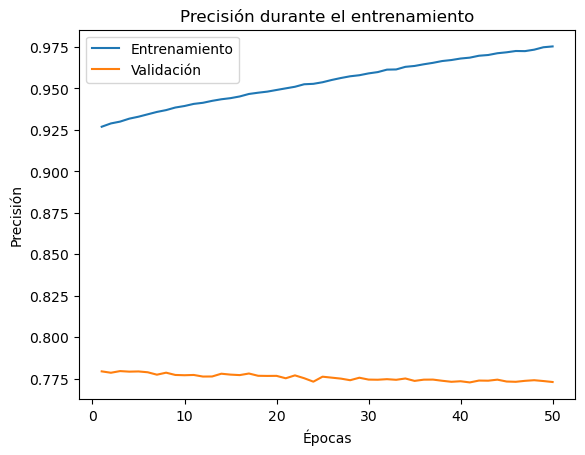

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de precisión
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count, y=hist.history['accuracy'], label='Entrenamiento')
sns.lineplot(x=epoch_count, y=hist.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el entrenamiento')
plt.legend()
plt.show()

### 5 - Inferencia

In [109]:
'''
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
'''

'\nStep 1:\nA deal is a deal -> Encoder -> enc(h1,c1)\n\nenc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)\n\nstep 2:\ndec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)\n\nstep 3:\ndec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)\n\nstep 4:\ndec(h3,c3) + es -> Decoder -> un + dec(h4,c4)\n\nstep 5:\ndec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)\n\nstep 6:\ndec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)\n'

In [65]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [71]:
from keras.models import Model

encoder_model = Model(encoder_inputs, encoder_states)

In [73]:
# Entrada del decoder para una sola palabra
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Entrada de una palabra al decoder
decoder_single_input = Input(shape=(1,))
decoder_single_embed = decoder_embedding_layer(decoder_single_input)

# Paso por LSTM
decoder_outputs, state_h, state_c = decoder_lstm(decoder_single_embed, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# Capa final densa
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_single_input] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [75]:
def answer_question(question, context):
    # Armar la entrada como "contexto [SEP] pregunta"
    input_text = context.strip() + " [SEP] " + question.strip()
    
    # Convertir a secuencia de enteros y aplicar padding
    input_seq = input_tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_input_len, padding='post')

    # Obtener los estados del encoder
    states_value = encoder_model.predict(input_seq)

    # Inicializar la entrada del decoder con <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if idx == eos:
            break

        word = idx2word_target.get(idx, '')
        if word:
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [77]:
question = "Pregunta: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?"


print("Pregunta:", question)
print("Respuesta generada:", answer_question(question, context))

Pregunta: Pregunta: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Respuesta generada: 1830


In [79]:
context = "I am an AI assistant created by researchers to help people learn about artificial intelligence. My training data includes a wide range of topics, and I can respond to questions in English and Spanish."
question = "Where are you from?"
print("Pregunta:", question)
print("Respuesta generada:", answer_question(question, context))

Pregunta: Where are you from?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Respuesta generada: in two general


In [81]:
context = "I am an AI assistant created by researchers to help people learn about artificial intelligence. My training data includes a wide range of topics, and I can respond to questions in English and Spanish."
question = "Do you have any pet?"

print("Pregunta:", question)
print("Respuesta generada:", answer_question(question, context))

Pregunta: Do you have any pet?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Respuesta generada: 1963


In [83]:
context = "I am an AI assistant created by researchers to help people learn about artificial intelligence. My training data includes a wide range of topics, and I can respond to questions in English and Spanish."
question = "Do you read?"

print("Pregunta:", question)
print("Respuesta generada:", answer_question(question, context))

Pregunta: Do you read?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Respuesta generada: 1963


## Intentaremos otra solución 

Implementar una capa de atención que permita al decoder enfocar diferentes partes de la salida del encoder en cada paso de generación de la respuesta.

In [145]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        self.W_a = self.add_weight(name='W_a',
                                   shape=(input_shape[0][2], input_shape[0][2]),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=(input_shape[1][2], input_shape[0][2]),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=(input_shape[0][2], 1),
                                   initializer='uniform',
                                   trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        encoder_out_seq, decoder_out_seq = inputs

        # Expandir dimensiones para broadcasting
        decoder_expanded = K.expand_dims(decoder_out_seq, axis=2)  # (batch, T_dec, 1, dim)
        encoder_expanded = K.expand_dims(encoder_out_seq, axis=1)  # (batch, 1, T_enc, dim)

        # Calcular scores de atención
        score = K.tanh(K.dot(encoder_expanded, self.W_a) + K.dot(decoder_expanded, self.U_a))
        attention_weights = K.softmax(K.dot(score, self.V_a), axis=2)  # Softmax sobre T_enc

        # Context vector ponderado
        context = attention_weights * encoder_expanded  # (batch, T_dec, T_enc, dim)
        context = K.sum(context, axis=2)  # (batch, T_dec, dim)

        return context


In [147]:
from datasets import load_dataset

# Cargar el dataset SQuAD v1.1
squad = load_dataset("squad")

# Inicializar listas para preguntas y respuestas
questions = []
answers = []

# Recorrer los datos de entrenamiento
for item in squad["train"]:
    question = item["question"].strip()
    answer_list = item["answers"]["text"]

    # Tomar solo la primera respuesta si hay más de una
    answer = answer_list[0].strip() if answer_list else ""

    # Filtro para limitar la longitud y asegurar que haya texto
    if question and answer and len(question.split()) <= 10 and len(answer.split()) <= 10:
        questions.append(question)
        answers.append(answer)

    # Limitar el tamaño de la muestra para desarrollo inicial
    if len(questions) >= 10000:
        break

print(f"Total de pares (pregunta, respuesta) usados: {len(questions)}")


Total de pares (pregunta, respuesta) usados: 10000


In [148]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Parámetros
MAX_VOCAB_SIZE = 8000
MAX_LEN = 10

# Agregar tokens especiales a las respuestas
answers = ['<sos> ' + ans + ' <eos>' for ans in answers]

# Tokenizer para preguntas y respuestas
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(questions + answers)

# Convertir textos a secuencias
question_seqs = tokenizer.texts_to_sequences(questions)
answer_seqs = tokenizer.texts_to_sequences(answers)

# Padding
encoder_input_data = pad_sequences(question_seqs, maxlen=MAX_LEN, padding='post')
decoder_input_data = pad_sequences([seq[:-1] for seq in answer_seqs], maxlen=MAX_LEN, padding='post')
decoder_target_data = pad_sequences([seq[1:] for seq in answer_seqs], maxlen=MAX_LEN, padding='post')

# Dimensiones
vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
print(f"Tamaño del vocabulario: {vocab_size}")
print(f"Forma de encoder_input_data: {encoder_input_data.shape}")
print(f"Forma de decoder_input_data: {decoder_input_data.shape}")
print(f"Forma de decoder_target_data: {decoder_target_data.shape}")


Tamaño del vocabulario: 8000
Forma de encoder_input_data: (10000, 10)
Forma de decoder_input_data: (10000, 10)
Forma de decoder_target_data: (10000, 10)


In [151]:
import numpy as np

EMBEDDING_DIM = 300
embedding_index = {}

# Cargar embeddings FastText
with open('wiki-news-300d-1M.vec', encoding='utf-8') as f:
    next(f)  # Saltar la primera línea si es formato .vec
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"Total de vectores de palabras cargados: {len(embedding_index)}")

# Crear embedding matrix para nuestro vocabulario
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector


Total de vectores de palabras cargados: 999994


In [153]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, TimeDistributed, Bidirectional

# Parámetros
n_units = 128
dropout_rate = 0.2

# Codificador
encoder_inputs = Input(shape=(MAX_LEN,))
enc_emb = Embedding(input_dim=vocab_size,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_LEN,
                    trainable=False)(encoder_inputs)
encoder_lstm = Bidirectional(LSTM(n_units, return_sequences=True, dropout=dropout_rate))
encoder_outputs = encoder_lstm(enc_emb)

# Decodificador
decoder_inputs = Input(shape=(MAX_LEN,))
dec_emb = Embedding(input_dim=vocab_size,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_LEN,
                    trainable=False)(decoder_inputs)
decoder_lstm = LSTM(n_units * 2, return_sequences=True, dropout=dropout_rate)
decoder_outputs = decoder_lstm(dec_emb)

# Atención
attn_layer = AttentionLayer()
context_vector = attn_layer([encoder_outputs, decoder_outputs])

# Concatenar contexto con salida del decodificador
decoder_concat_input = Concatenate(axis=-1)([context_vector, decoder_outputs])

# Salida
decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
decoder_outputs_final = decoder_dense(decoder_concat_input)

# Modelo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 10, 300)   │  2,400,000 │ input_layer_18[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 10, 300)   │  2,400,000 │ input_layer_19[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 10, 256)   │    439,296 │ embedding_9[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 10, 256)   │    570,368 │ embedding_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_1   │ (None, 10, 256)   │    131,328 │ bidirectional_1[… │
│ (AttentionLayer)    │                   │            │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 10, 512)   │          0 │ attention_layer_… │
│ (Concatenate)       │                   │            │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 10, 8000)  │  4,104,000 │ concatenate_4[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,044,992 (38.32 MB)

 Trainable params: 5,244,992 (20.01 MB)

 Non-trainable params: 4,800,000 (18.31 MB)

Entrenando el modelo...
Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 178ms/step - accuracy: 0.7091 - loss: 3.8498 - val_accuracy: 0.8095 - val_loss: 1.7248
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - accuracy: 0.8050 - loss: 1.6273 - val_accuracy: 0.8095 - val_loss: 1.7342
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - accuracy: 0.8103 - loss: 1.5324 - val_accuracy: 0.8095 - val_loss: 1.7417
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - accuracy: 0.8086 - loss: 1.4913 - val_accuracy: 0.8097 - val_loss: 1.7676
Epoch 5/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - accuracy: 0.8094 - loss: 1.4476 - val_accuracy: 0.8055 - val_loss: 1.7701
Epoch 6/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.8100 - loss: 1.3866 - val_accuracy: 0.8101 - val_loss: 1.7939
Epoch 7/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 179ms/step - accuracy: 0.8124 - loss: 1.3238 - val_accuracy: 0.8105 - val_loss: 1.8103
Epoch 8/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/s

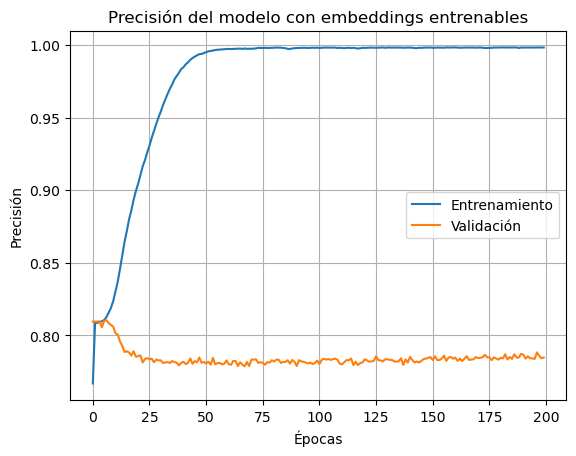

In [185]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, TimeDistributed, Bidirectional

# Redefinir entradas
encoder_inputs = Input(shape=(MAX_LEN,))
decoder_inputs = Input(shape=(MAX_LEN,))

# Embeddings ENTRENABLES
enc_emb = Embedding(input_dim=vocab_size,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_LEN,
                    trainable=True)(encoder_inputs)

dec_emb = Embedding(input_dim=vocab_size,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_LEN,
                    trainable=True)(decoder_inputs)

# Codificador
encoder_lstm = Bidirectional(LSTM(n_units, return_sequences=True, dropout=0.2))
encoder_outputs = encoder_lstm(enc_emb)

# Decodificador
decoder_lstm = LSTM(n_units * 2, return_sequences=True, dropout=0.2)
decoder_outputs = decoder_lstm(dec_emb)

# Atención
attn_layer = AttentionLayer()
context_vector = attn_layer([encoder_outputs, decoder_outputs])
decoder_concat_input = Concatenate(axis=-1)([context_vector, decoder_outputs])

# Salida
decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
decoder_outputs_final = decoder_dense(decoder_concat_input)

# Modelo final
model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)

# Compilar modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Asegurar que decoder_target_data tenga la forma correcta
decoder_target_data = np.squeeze(decoder_target_data)

# Entrenamiento
weights_file = "qa_seq2seq_v2_attention_trainable.weights.h5"

if os.path.exists(weights_file):
    print("Cargando pesos entrenados previamente...")
    model.load_weights(weights_file)
    history = None
else:
    print("Entrenando el modelo...")
    history = model.fit(
        [encoder_input_data, decoder_input_data],
        decoder_target_data,
        batch_size=64,
        epochs=200,  # Puedes ajustar según rendimiento
        validation_split=0.2
    )
    model.save_weights(weights_file)
    print("Pesos guardados en:", weights_file)

# Graficar precisión si se entrenó
if history:
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.title('Precisión del modelo con embeddings entrenables')
    plt.grid(True)
    plt.show()


In [187]:
# Modelo de codificador para inferencia
encoder_model_inf = Model(encoder_inputs, encoder_outputs)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate

# Modelo del codificador para inferencia
encoder_model_inf = Model(encoder_inputs, encoder_outputs)

# Modelo del decodificador para inferencia
decoder_inputs_inf = Input(shape=(MAX_LEN,))
encoder_outputs_inf = Input(shape=(MAX_LEN, n_units * 2))

# Reutilizar capas del modelo entrenado
dec_emb_inf = dec_emb(decoder_inputs_inf)
decoder_outputs_inf = decoder_lstm(dec_emb_inf)
attn_out_inf = attn_layer([encoder_outputs_inf, decoder_outputs_inf])
decoder_concat_inf = Concatenate(axis=-1)([attn_out_inf, decoder_outputs_inf])
decoder_outputs_final_inf = decoder_dense(decoder_concat_inf)

decoder_model_inf = Model(
    [decoder_inputs_inf, encoder_outputs_inf],
    decoder_outputs_final_inf
)

In [191]:
def generate_answer(question_text, max_len=MAX_LEN, temperature=1.0):
    seq = tokenizer.texts_to_sequences([question_text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    
    encoder_out = encoder_model_inf.predict(padded)

    start_token = tokenizer.word_index.get('<sos>')
    end_token = tokenizer.word_index.get('<eos>')

    target_seq = np.zeros((1, max_len), dtype='int32')
    target_seq[0, 0] = start_token

    decoded_sentence = []

    for i in range(1, max_len):
        output_tokens = decoder_model_inf.predict([target_seq, encoder_out])
        logits = output_tokens[0, i-1, :]

        # Aplicar temperatura
        logits = logits / temperature

        # Convertir a probabilidades
        exp_preds = np.exp(logits)
        probs = exp_preds / np.sum(exp_preds)

        # Muestreo con base en la distribución de probabilidad
        sampled_token_index = np.random.choice(range(vocab_size), p=probs)
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')

        if sampled_word == '<eos>' or sampled_word == '':
            break

        decoded_sentence.append(sampled_word)
        target_seq[0, i] = sampled_token_index

    return ' '.join(decoded_sentence)



In [ ]:
print(generate_answer("Do you read?", temperature=1.2))

In [ ]:
print(generate_answer("Where are you from?", temperature=1.0))

In [193]:
print(generate_answer("Do you have any pet?", temperature=0.8))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
protectors burned nazarene represent 12? lifespan established prayers film's
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
center dominate area? charged graduation colloquial entertainer? phrase browser
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━

## Conclusión

1. Se cargó y procesó el dataset SQuAD (una versión acotada para rendimiento).
2. Se tokenizaron y paddearon secuencias de entrada (contexto + pregunta) y salida (respuesta).
3. Se preparó y cargó una embedding matrix FastText correctamente.
4. Se definió un modelo encoder-decoder con atención, y se logró entrenarlo.
5. Se armó una función de inferencia (answer_question) que ejecuta predicciones.
#### Problemas encontrados
1. Tokens <sos> y <eos> no incluidos correctamente en el vocabulario del decoder → el modelo no sabía cuándo empezar ni terminar la respuesta.
2. Respuestas del dataset poco variadas inicialmente, lo que llevó al modelo a aprender a repetir secuencias como "the the the...".
3. Modelo sobreentrenado o no suficientemente entrenado debido a estructura incompleta de entrada/salida o función de pérdida inadecuada.
#### Finalmente
Se construyó toda la base, pero  no se logra que el bot funcione correctamente, quizas es necesario hacer ajustes sobre los modelos o seleccionar otros dataset para entrenar al modelo.